In [2]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import warnings 
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
from utils import *
torch.cuda.is_available()

True

In [3]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv')
tag_map = dict(zip(tag['TAG'],tag['chinese']))

In [4]:
critic = joblib.load('./model/net.pkl')
critic = critic.eval()
mm_x = joblib.load('./model/mm_x.pkl')
mm_y = joblib.load('./model/mm_y.pkl')

# def columns

In [5]:
x_cols = [
          'MLPAP_FR-0632.PV',
          'MLPAP_LIC-0738.PV',
          'MLPAP_LRC-0729.PV',
          'MLPAP_PIC-0761.PV',
          'MLPAP_TJ-0757B.PV',
          'MLPAP_TJC-0627.PV',
          'MLPAP_TJC-0757.PV',
          'MLPAP_TJC-0757A.PV',
          'MLPAP_TJC-1721.PV',
          'MLPAP_TRC-0610.PV',
          'MLPAP_TRC-0747.PV',
          'MLPAP_TRC-0762.PV',
          'MLPAP_TRC-1734.PV']
x_cols = sorted(x_cols)
x_cols.insert(0,'MLPAP_FQ-0619.PV')
x_cols

['MLPAP_FQ-0619.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [6]:
y_cols = ['MLPAP_FQI-0997.PV']

# critic forward test

In [7]:
x = np.random.normal(loc=0,scale=1,size=(39,14))
x = pd.DataFrame(x,columns=x_cols)
x.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,0.702248,-1.617056,-1.190028,0.324814,0.664555,-2.060083,-0.298802,0.604010,-0.622846,0.903356,1.052127,0.341576,0.663216,0.912070
1,-2.020498,1.908177,0.599548,0.585085,-0.238660,1.620397,1.747685,0.189342,-0.090745,-2.583020,-0.729370,0.832515,-0.905652,-1.676239
2,-1.818107,-2.959541,1.027179,-1.162553,0.168628,-0.600662,-0.216025,1.348244,0.185145,-0.726815,0.173293,0.401923,0.851438,1.240059
3,0.218220,0.451135,-0.132905,1.377330,1.484656,0.100520,0.498830,-0.044654,0.400803,0.403120,-0.939450,0.024444,0.620377,-1.002568
4,1.550043,-0.654851,-0.338552,0.122619,1.200244,-2.683724,-0.695085,-0.639245,0.924207,-0.858802,-0.306841,-0.152675,1.134854,1.126033


In [8]:
y = critic(torch.tensor(x.values.reshape(-1,39*14)).cuda())
print(y)
y = mm_y.inverse_transform(y.detach().cpu().numpy())
y

tensor([[0.8177]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)


array([[9089.05167071]])

# build generator

In [9]:
def build_generator(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),
        ReLU(),
        Linear(256,output_shape),
        Sigmoid()
    )
    return net

In [10]:
def init_weights(m):
  if hasattr(m,'weight'):
    torch.nn.init.xavier_uniform(m.weight)
  if hasattr(m,'bias'):  
    m.bias.data.fill_(0)

In [11]:
net = build_generator(1,39*14).double().cuda()
net.apply(init_weights)
net

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=546, bias=True)
  (3): Sigmoid()
)

# noise_iter

In [12]:
noise = torch.tensor(np.random.normal(loc=0,scale=1,size=(5000,1))).cuda()
noise_datasets = torch.utils.data.TensorDataset(noise)
noise_iter = torch.utils.data.DataLoader(noise_datasets,batch_size=128)
noise_iter

# obj function

In [13]:
obj_function = lambda x:critic(x).mean()

# optimizer

In [14]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train

In [15]:
def train(net,noise_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        for noise in noise_iter:
            noise = noise[0]
            z = net(noise).cuda()
            loss = obj_function(z)
            loss *= -1
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    # return trained net
    return net

epochs 0 loss -0.4312
epochs 1 loss -0.5078
epochs 2 loss -0.5993
epochs 3 loss -0.6925
epochs 4 loss -0.7739
epochs 5 loss -0.8381
epochs 6 loss -0.8852
epochs 7 loss -0.9180
epochs 8 loss -0.9402
epochs 9 loss -0.9552
epochs 10 loss -0.9654
epochs 11 loss -0.9726
epochs 12 loss -0.9778
epochs 13 loss -0.9817
epochs 14 loss -0.9846
epochs 15 loss -0.9869
epochs 16 loss -0.9887
epochs 17 loss -0.9901
epochs 18 loss -0.9913
epochs 19 loss -0.9923
epochs 20 loss -0.9931
epochs 21 loss -0.9938
epochs 22 loss -0.9944
epochs 23 loss -0.9949
epochs 24 loss -0.9954
epochs 25 loss -0.9957
epochs 26 loss -0.9961
epochs 27 loss -0.9964
epochs 28 loss -0.9966
epochs 29 loss -0.9969


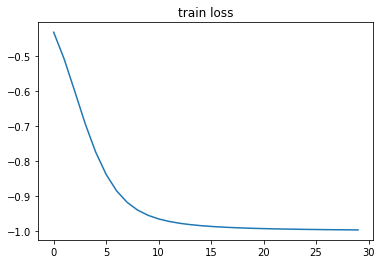

In [16]:
net = train(net,noise_iter,obj_function,optimizer,num_epochs=30)

# result

In [17]:
output = critic(net(noise)).detach().cpu().numpy()
output = mm_y.inverse_transform(output)
output = pd.DataFrame(output,columns=['0997'])
output

,0997
0,9995.316507
1,9986.406227
2,9978.316732
3,9997.579018
4,9995.845143
...,...
4995,9984.660248
4996,9992.967296
4997,9971.505740
4998,9987.165907


In [18]:
best_idx = np.argmax(output.values)
output.loc[[best_idx]]

,0997
4092,9998.891428


In [19]:
result = pd.DataFrame(net(noise).detach().cpu().numpy())
result[:] = mm_x.inverse_transform(result)
r1 = result.iloc[best_idx,:].values.reshape(39,14)
r1 = pd.DataFrame(r1,columns=x_cols)
r1.loc['median'] = r1.median(axis=0)
r1

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,7814.587796,64.846009,24.618747,31.712987,48.815750,361.327091,143.294925,2.741913,346.367768,66.948013,163.815537,163.958261,350.267417,198.809777
1,4485.192467,86.129587,51.958826,56.670524,49.645477,361.112650,157.842801,2.811053,346.613383,56.139896,191.614713,163.967365,364.047991,161.203768
2,7824.712929,85.675573,53.117965,31.844784,48.834873,346.334338,157.377042,-2.152680,346.469049,55.999619,190.745161,180.069147,364.083297,163.792916
3,7751.485502,65.038530,35.136359,31.489845,48.846715,361.599586,157.440138,-2.238632,360.499317,66.475467,190.821858,164.336388,349.563125,197.800099
4,7722.001117,86.023645,53.034531,31.450350,49.692827,361.244215,143.661144,-2.007098,347.217043,67.180804,164.672262,179.476838,364.275776,161.742640
5,7843.698744,86.049864,52.648390,31.149429,49.686127,346.222572,143.235243,-1.913929,346.520429,55.510768,190.299096,164.313631,350.045176,162.023673
6,7812.014032,85.275941,52.255364,56.763502,48.809436,361.679707,157.474221,2.633566,346.706506,55.868718,191.067438,164.108958,350.329209,198.410584
7,4579.027423,85.594821,36.023225,31.832493,48.827415,361.484812,143.057238,-1.780921,360.385316,55.725529,164.608612,164.137455,363.145712,197.932776
8,7802.140169,84.940826,52.899787,31.457854,49.669660,361.530191,143.222235,-1.729104,347.096638,55.608295,189.565237,179.302711,349.815937,197.648918
9,7817.211098,86.197655,53.424665,56.750774,48.801292,361.468721,143.229481,2.694464,346.279494,55.425647,164.756319,163.949090,349.550748,162.307195


In [20]:
r1 = r1.loc[['median']].T
r1['chinese'] = r1.index.map(tag_map)
r1 = r1[['chinese','median']]

In [21]:
print('best control factor maybe:')
r1

best control factor maybe:


,chinese,median
MLPAP_FQ-0619.PV,OX入料量,7757.211318
MLPAP_FR-0632.PV,汽機風量,85.472930
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,51.726737
MLPAP_LRC-0729.PV,鍋爐水液位控制,55.457025
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,48.846715
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,361.295507
MLPAP_TJC-0627.PV,OX預熱器出口溫度,143.661144
MLPAP_TJC-0757.PV,反應器A/B側鹽浴溫度差,-1.442459
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,346.813720
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,55.877506
